## Accessing Forest Inventory and Analysis data with the Planetary Computer STAC API

This notebook demonstrates accessing [Forest Inventory and Analysis](https://planetarycomputer.microsoft.com/dataset/fia) (FIA) data from the Planetary Computer STAC API.

The Forest Inventory and Analysis collection contains many tables, and each STAC table corresponds to one STAC item in the [FIA collection](http://planetarycomputer.microsoft.com/api/stac/v1/collections/fia). In this example, we'll use a few of the tables to estimate the total amount of aboveground carbon, in pounds, per US county.

This example builds on the [plot estimation](https://rfia.netlify.app/courses/plt_est/) example from the [rfia](https://rfia.netlify.app/) package.

In [1]:
from cartopy import crs as ccrs
from dask_gateway import GatewayCluster
import dask_geopandas
import dask.dataframe as dd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer

The `tree` table below is relatively large, so we'll process it in parallel on a Dask cluster. The example will still run without a cluster, it will just take longer.

In [2]:
cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
cluster

### Data Access

We'll use two datsaets

* `tree`: Information on each tree 1″ in diameter or larger, linked to `plot` and `cond`.
* `plot`: Information relevant to each 1-acre field plot where the samples were collected.

All of these are available in Azure Blob Storage as parquet datasets that can be read, for example, by `dask.dataframe`.

In [3]:
import pystac_client

catalog = pystac_client.Client.open(
    "http://planetarycomputer.microsoft.com/api/stac/v1"
)
fia = catalog.get_collection("fia")
fia

<CollectionClient id=fia>

As usual, we sign the items before trying to access the data.

In [4]:
plot_item = planetary_computer.sign(fia.get_item("plot"))
tree_item = planetary_computer.sign(fia.get_item("tree"))

And now we can read the items using `dask.dataframe`. We make sure to pass the `storage_options` included in the `data` asset.

In [5]:
plot = dd.read_parquet(
    plot_item.assets["data"].href,
    columns=["CN", "STATECD", "COUNTYCD"],
    storage_options=plot_item.assets["data"].extra_fields["table:storage_options"],
    engine="pyarrow",
)
tree = dd.read_parquet(
    tree_item.assets["data"].href,
    columns=["PLT_CN", "CONDID", "TREE", "DRYBIO_AG", "CARBON_AG", "TPA_UNADJ"],
    storage_options=tree_item.assets["data"].extra_fields["table:storage_options"],
    engine="pyarrow",
    filters=[("CONDID", "==", 1)],
)

### Join the datasets

The three datasets can be joined on their various keys. Since `tree` is relatively large, we'll join the other (smaller, in-memory) dataframes to it.

In [6]:
df = tree.merge(plot.assign(PLT_CN=plot.CN).compute(), on="PLT_CN").assign(
    bio=lambda df: df.DRYBIO_AG * df.TPA_UNADJ / 2000,
    carbon=lambda df: df.CARBON_AG * df.TPA_UNADJ / 2000,
)
df

,PLT_CN,CONDID,TREE,DRYBIO_AG,CARBON_AG,TPA_UNADJ,CN,STATECD,COUNTYCD,bio,carbon
npartitions=160,,,,,,,,,,,
,int64,int64,int64,float64,float64,float64,int64,int64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


### Compute per-county summaries

The `df` dataframe now includes the state and county FIPS codes, and the (adjusted) aboveground carbon and biomass. We'll group by the geographic boundaries and sum the aboveground carbon and biomass.

In [7]:
%%time
result = (
    df.groupby(["STATECD", "COUNTYCD"])[["bio", "carbon"]]
    .sum()
    .compute()
    .reset_index()
    .assign(
        STATE=lambda df: df["STATECD"].astype("string").str.pad(2, fillchar="0"),
        COUNTY=lambda df: df["COUNTYCD"].astype("string").str.pad(3, fillchar="0"),
    )
    .drop(columns=["STATECD", "COUNTYCD"])
)
result.head()

CPU times: user 129 ms, sys: 39.2 ms, total: 168 ms
Wall time: 21 s


,bio,carbon,STATE,COUNTY
0,9130.179946,4565.090000,01,001
1,27163.826785,13565.771340,01,003
2,15567.843806,7774.593220,01,005
3,16643.533828,8321.766954,01,007
4,8742.498366,4364.876867,01,009


### Plot the results

Now we'll make a chloropleth for the results. We just need to join in the actual geographic boundaries of the datasets, which we can get with geopandas.

In [8]:
census_item = planetary_computer.sign(
    catalog.get_collection("us-census").get_item("2020-cb_2020_us_county_500k")
)

counties = (
    dask_geopandas.read_parquet(
        census_item.assets["data"].href,
        storage_options=census_item.assets["data"].extra_fields[
            "table:storage_options"
        ],
        columns=["STATEFP", "COUNTYFP", "geometry"],
    ).rename(columns={"STATEFP": "STATE", "COUNTYFP": "COUNTY"})
).compute()

Finally, we'll slice the data down to the continental United States (the dataset covers Hawaii, Alaska, and several other territories).

In [9]:
gdf = geopandas.GeoDataFrame(pd.merge(result, counties, on=["STATE", "COUNTY"]))
df_conus = gdf.cx[-124.784:-66.951, 24.744:49.346]
df_conus.head()

,bio,carbon,STATE,COUNTY,geometry
0,9130.179946,4565.090000,01,001,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
1,27163.826785,13565.771340,01,003,"POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
2,15567.843806,7774.593220,01,005,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
3,16643.533828,8321.766954,01,007,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
4,8742.498366,4364.876867,01,009,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."


Finally, we'll plot the (log) of the estimated carbon stored above ground by the trees.

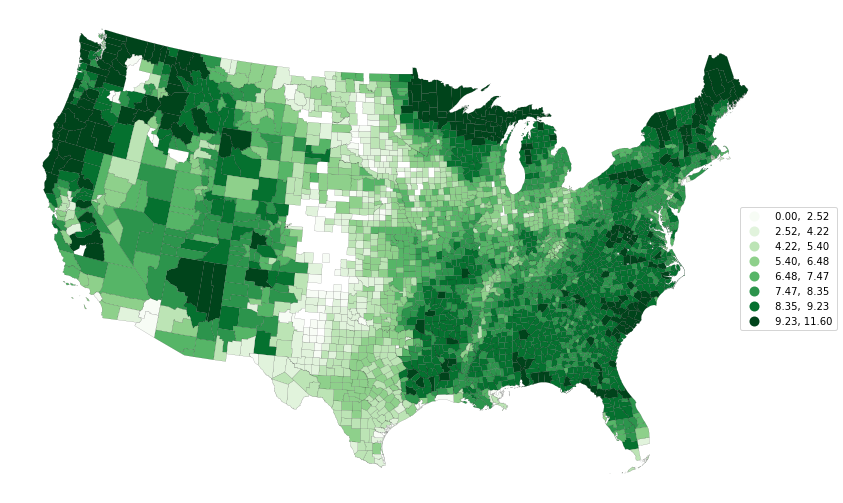

In [10]:
crs = ccrs.LambertConformal()
fig, ax = plt.subplots(subplot_kw={"projection": crs}, figsize=(16, 9))
df_conus.assign(carbon=np.log(df_conus.carbon + 1)).to_crs(crs.proj4_init).plot(
    column="carbon",
    cmap="Greens",
    edgecolor="k",
    scheme="natural_breaks",
    k=8,
    ax=ax,
    linewidths=0.1,
    legend=True,
)

# Shift the legend
bbox = ax.legend_.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
bbox.x0 += 0.075
bbox.x1 += 0.075
bbox.y0 -= 0.4
bbox.y1 -= 0.4
ax.legend_.set_bbox_to_anchor(bbox)

ax.axis("off");

### Next Steps

Now that you've an introduction to the Forest Inventory and Analysis dataset, learn more with

* The [Reading tabular data quickstart](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-tabular-data/) for an introduction to tabular data on the Planeatry Computer